Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [x] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [x] Plot a confusion matrix for your Tanzania Waterpumps model.
- [x] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [x] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [x] Commit your notebook to your fork of the GitHub repo.
- [x] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

## My model's data cleaning steps

In [0]:
import numpy as np
def Data_cleaning(X):
 
    # make a copy of the data
    X = X.copy()
    # get rid of outliers  
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    
    cols_with_zeros = ['longitude', 'latitude','population','construction_year']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)

  # add try catch to ignore rerun of cell 
    try:        
        # drop redundant column
        X = X.drop(columns='quantity_group')
        X=X.drop('recorded_by',axis=1)
    
        # change 'unkown' to nan
        X['source_class']=X['source_class'].replace("unknown",np.NaN)

    # not a dup but not usefull %0 variance
    except:
        print("Cell is rerun")

    # define a list of columns to iterate through
    # originially this was an argument for the function but i moved it inside
    column=['funder','installer','region','scheme_name']
    # if a list is passed then make changes for all elements in that list of column names
    if isinstance(column,list):
        for ele in column:
            top10=X[ele].value_counts()[:25].index
            X.loc[~X[ele].isin(top10), ele] = 'other'
    # if one name is passed then just change that one column
    else:
        top10=X[column].value_counts()[:25].index
        X.loc[~X[column].isin(top10), column] = 'other'
  
    # convert date to time series then drop time series
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year'] = X['date_recorded'].dt.year
    X['month'] = X['date_recorded'].dt.month
    X['day'] = X['date_recorded'].dt.day
    try:
        X = X.drop(columns='date_recorded')
    except:
        print('cell rerun')
    
    # Engineer feature: how old is the waterpump
    X['age'] = X['year'] - X['construction_year']
    X['age_missing'] = X['age'].isnull()
    return X
train=Data_cleaning(train)
test=Data_cleaning(test)

In [64]:
train.region.value_counts()

Iringa           5294
Shinyanga        4982
Mbeya            4639
Kilimanjaro      4379
Morogoro         4006
Arusha           3350
Kagera           3316
Mwanza           3102
Kigoma           2816
Ruvuma           2640
Pwani            2635
Tanga            2547
Dodoma           2201
Singida          2093
Mara             1969
Tabora           1959
Rukwa            1808
Mtwara           1730
Manyara          1583
Lindi            1546
Dar es Salaam     805
Name: region, dtype: int64

In [0]:
from sklearn.model_selection import train_test_split

In [65]:
# select target and features for prediction
target = 'status_group'
ignore=['date_recorded','id',target]
cat_features=[x for x in train.describe(exclude='number').columns.to_list() if x not in ignore]
num_features=[x for x in train.describe(include='number').columns.to_list() if x not in ignore]

# Get a series with the cardinality of the nonnumeric features
cardinality = train[cat_features].select_dtypes(exclude='number').nunique()
# Get a list of all categorical features with cardinality <= 50
#cat_features = cardinality[cardinality <= 50].index.tolist()
cat_features = cardinality[cardinality <= 100].index.tolist()

# set features and target
target = 'status_group'
features = cat_features + num_features

train,val=train_test_split(train)

# make feature sets and labels
X_train=train[features]
X_val=val[features]

y_train=train[target]
y_val=val[target]

# make test feature set
X_test=test[features]

print(f"train shape:{train.shape}\n\
validation shape:{val.shape}\n\
testing shape:{test.shape}")

train shape:(44550, 43)
validation shape:(14850, 43)
testing shape:(14358, 42)


In [0]:
# import preprocessing stuff
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder,OrdinalEncoder
from sklearn.preprocessing import StandardScaler,MinMaxScaler

# imputer
from sklearn.impute import SimpleImputer

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# import test metrics
from sklearn.metrics import accuracy_score,confusion_matrix


In [0]:
model=XGBClassifier(objective = 'multi:softmax', booster = 'gbtree', nrounds = 'min.error.idx', 
                      num_class = 3, maximize = False, eval_metric = 'merror', eta = .1,
                      max_depth = 14, colsample_bytree = .4)

In [0]:
model_pipe=make_pipeline(
                        OneHotEncoder(use_cat_names=True),
                        SimpleImputer(),
                        StandardScaler(),
                        model
                        )

In [29]:
model_pipe.fit(X_train,y_train)
y_pred=model_pipe.predict(X_train)
print(f"RandomForest_pipe:\n\tTRAIN ACCURACY:{accuracy_score(y_pred=y_pred,y_true=y_train)}")
y_pred=model_pipe.predict(X_val)
print(f"\tVALIDATION ACCURACY:{accuracy_score(y_pred=y_pred,y_true=y_val)}")

RandomForest_pipe:
	TRAIN ACCURACY:0.937283950617284
	VALIDATION ACCURACY:0.814006734006734


## confusion matrix

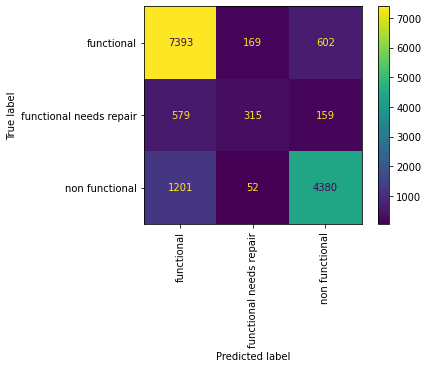

In [31]:
from sklearn.metrics import plot_confusion_matrix
cm=plot_confusion_matrix(model_pipe,X_val,y_val,values_format='.0f',xticks_rotation='vertical')
cm;

In [32]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true=y_val,y_pred=y_pred)

array([[7393,  169,  602],
       [ 579,  315,  159],
       [1201,   52, 4380]])